In [1]:
import pandas as pd
import os 
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook as tqdm
import numpy as np
import joblib
import matplotlib.pyplot as plt
root = '../data/phase_2/cleaned/'
os.listdir(root)

['col_names.pkl', 'train.csv']

In [2]:
col_names = joblib.load('../data/phase_2/cleaned/col_names.pkl')
col_names.keys()

dict_keys(['xna', 'xle', 'xhc', 'xhe', 'fna', 'fle', 'fhc', 'fhe', 'sle', 'shc', 'she', 'case'])

In [3]:
def get_col(df,name):
    return df.columns[df.columns.str.contains(name)].tolist()

# load data

In [4]:
df = pd.read_csv(root+'train.csv',index_col=0)
df.head()

,Case Conditions_Feed Rate to C013 (Input)_m3/hr,Case Conditions_Heart Cut Prod. Rate (Input)_m3/hr,Case Conditions_C7+ in Light End (Input)_wt%,Case Conditions_C6P- in Heart Cut (Input)_wt%,Naphtha Properties_Oxygen_wt%,Naphtha Properties_Methane_wt%,Naphtha Properties_Ethane_wt%,Naphtha Properties_Propane_wt%,Naphtha Properties_n-Butane_wt%,Naphtha Properties_i-Pentane_wt%,...,"Individual Component to Heavy End Split Factor_2,2,3,3-Tetramethylhexane_Ratio",Individual Component to Heavy End Split Factor_3-Methylnonane_Ratio,Individual Component to Heavy End Split Factor_tert-Butylcyclohexane_Ratio,Individual Component to Heavy End Split Factor_n-Decane_Ratio,"Individual Component to Heavy End Split Factor_1,2-Diethylbenzene_Ratio",Individual Component to Heavy End Split Factor_n-Undecane_Ratio,Individual Component to Heavy End Split Factor_n-Pentylbenzene_Ratio,Individual Component to Heavy End Split Factor_n-Dodecane_Ratio,Individual Component to Heavy End Split Factor_n-Hexylbenzene_Ratio,Individual Component to Heavy End Split Factor_n-Tridecane_Ratio
001-01,10.0,100.0,2.5,1.0,0.0,0.0,0.0,0.002,0.003,0.025999,...,0.348342,0.378793,0.381912,0.397334,0.409138,0.433925,0.440811,0.451332,0.454764,1.0
001-02,10.0,100.0,5.0,1.0,0.0,0.0,0.0,0.002,0.003,0.025999,...,0.336983,0.367462,0.370631,0.386031,0.397878,0.422758,0.429677,0.440263,0.443717,1.0
001-03,10.0,100.0,10.0,1.0,0.0,0.0,0.0,0.002,0.003,0.025999,...,0.323372,0.354403,0.357728,0.373260,0.385311,0.410579,0.417606,0.428374,0.431884,1.0
001-04,10.0,100.0,2.5,1.5,0.0,0.0,0.0,0.002,0.003,0.025999,...,0.334064,0.360351,0.362654,0.376680,0.387033,0.409416,0.415640,0.425230,0.428354,1.0
001-05,10.0,100.0,5.0,1.5,0.0,0.0,0.0,0.002,0.003,0.025999,...,0.323809,0.350009,0.352356,0.366307,0.376672,0.399048,0.405285,0.414893,0.418027,1.0


# define columns

In [5]:
xna_col = col_names['xna']
sp_le_col = col_names['sle']
sp_hc_col = col_names['shc']
sp_he_col = col_names['she']
sp_col_162 = sp_le_col + sp_hc_col + sp_he_col

# get xna and sp162

In [6]:
xna = df[xna_col]
sp162 = df[sp_col_162]

# build transformer

In [7]:
class transformerB(object):
    def __init__(self):
        # output columns
        self.le = col_names['xle']
        self.hc = col_names['xhc']
        self.he = col_names['xhe']
        
        # split factor columns
        self.le_sp = col_names['sle']
        self.hc_sp = col_names['shc']
        self.he_sp = col_names['she']
    
    @staticmethod
    def _calculate_output(X,S,col_name):
        X, S = X.values, S.values
        F = np.diag(X@(S.T)).reshape(-1,1)
        Y = 100*(X*S)/(F)
        return pd.DataFrame(Y,columns=col_name)
    
    def __call__(self,xna,sp162):
        sle = sp162[self.le_sp] #SLE
        shc = sp162[self.hc_sp] #SHC
        she = sp162[self.he_sp] #SHE
        x_le = self._calculate_output(xna,sle,self.le) #XLE
        x_hc = self._calculate_output(xna,shc,self.hc) #XHC
        x_he = self._calculate_output(xna,she,self.he) #XHE
        return pd.concat([x_le,x_hc,x_he],axis=1)

# make transform

In [8]:
tr = transformerB()
y_pred = tr(xna,sp162)
y_pred

,Light End Product Properties_Oxygen_wt%,Light End Product Properties_Methane_wt%,Light End Product Properties_Ethane_wt%,Light End Product Properties_Propane_wt%,Light End Product Properties_n-Butane_wt%,Light End Product Properties_i-Pentane_wt%,Light End Product Properties_n-Pentane_wt%,Light End Product Properties_tr2-Pentene_wt%,Light End Product Properties_Cyclopentane_wt%,Light End Product Properties_3-Methylpentane_wt%,...,"Heavy End Product Properties_2,2,3,3-Tetramethylhexane_wt%",Heavy End Product Properties_3-Methylnonane_wt%,Heavy End Product Properties_tert-Butylcyclohexane_wt%,Heavy End Product Properties_n-Decane_wt%,"Heavy End Product Properties_1,2-Diethylbenzene_wt%",Heavy End Product Properties_n-Undecane_wt%,Heavy End Product Properties_n-Pentylbenzene_wt%,Heavy End Product Properties_n-Dodecane_wt%,Heavy End Product Properties_n-Hexylbenzene_wt%,Heavy End Product Properties_n-Tridecane_wt%
0,0.0,0.0,0.0,0.031463,0.046894,0.401970,1.138108,0.015390,0.196111,19.816850,...,5.498116,13.956124,2.497176,5.281884,3.507997,1.090498,0.220558,0.020529,0.041371,0.0
1,0.0,0.0,0.0,0.029677,0.044222,0.378933,1.072705,0.014506,0.184733,18.650427,...,5.565874,14.167475,2.535975,5.369975,3.569902,1.111782,0.224973,0.020956,0.042241,0.0
2,0.0,0.0,0.0,0.027325,0.040709,0.348719,0.987031,0.013348,0.169893,17.142468,...,5.754648,14.722090,2.637227,5.594397,3.724860,1.163364,0.235584,0.021969,0.044298,0.0
3,0.0,0.0,0.0,0.034538,0.051420,0.439840,1.243597,0.016820,0.212587,20.744602,...,4.928049,12.408690,2.216235,4.679968,3.101525,0.961640,0.194369,0.018078,0.036421,0.0
4,0.0,0.0,0.0,0.032552,0.048452,0.414280,1.171055,0.015839,0.199986,19.467864,...,4.967569,12.534007,2.239314,4.732872,3.139065,0.974726,0.197096,0.018343,0.036962,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14843,0.0,0.0,0.0,1.298106,2.542351,20.598131,19.596767,0.508198,2.097699,16.595299,...,1.719414,4.213681,0.508897,1.865204,1.087082,0.378445,0.066883,0.008494,0.012845,0.0
14844,0.0,0.0,0.0,1.271060,2.468864,19.759333,18.731648,0.485872,2.017195,16.913946,...,1.856814,4.562272,0.551647,2.022603,1.180397,0.411111,0.072681,0.009230,0.013960,0.0
14845,0.0,0.0,0.0,1.317078,2.599066,21.293316,20.311554,0.526668,2.152347,16.065631,...,1.609842,3.936431,0.475111,1.740281,1.013332,0.352447,0.062269,0.007905,0.011954,0.0
14846,0.0,0.0,0.0,1.285722,2.508491,20.208793,19.196071,0.497854,2.062281,16.805429,...,1.750710,4.291770,0.518403,1.900005,1.107448,0.385453,0.068116,0.008649,0.013079,0.0


In [9]:
y_real = df[y_pred.columns]
y_real

,Light End Product Properties_Oxygen_wt%,Light End Product Properties_Methane_wt%,Light End Product Properties_Ethane_wt%,Light End Product Properties_Propane_wt%,Light End Product Properties_n-Butane_wt%,Light End Product Properties_i-Pentane_wt%,Light End Product Properties_n-Pentane_wt%,Light End Product Properties_tr2-Pentene_wt%,Light End Product Properties_Cyclopentane_wt%,Light End Product Properties_3-Methylpentane_wt%,...,"Heavy End Product Properties_2,2,3,3-Tetramethylhexane_wt%",Heavy End Product Properties_3-Methylnonane_wt%,Heavy End Product Properties_tert-Butylcyclohexane_wt%,Heavy End Product Properties_n-Decane_wt%,"Heavy End Product Properties_1,2-Diethylbenzene_wt%",Heavy End Product Properties_n-Undecane_wt%,Heavy End Product Properties_n-Pentylbenzene_wt%,Heavy End Product Properties_n-Dodecane_wt%,Heavy End Product Properties_n-Hexylbenzene_wt%,Heavy End Product Properties_n-Tridecane_wt%
001-01,0.0,0.0,0.0,0.031463,0.046894,0.401970,1.138108,0.015390,0.196111,19.816853,...,5.498116,13.956123,2.497176,5.281883,3.507996,1.090498,0.220558,0.020529,0.041371,0.0
001-02,0.0,0.0,0.0,0.029677,0.044222,0.378933,1.072704,0.014506,0.184733,18.650423,...,5.565875,14.167476,2.535975,5.369976,3.569902,1.111782,0.224973,0.020956,0.042241,0.0
001-03,0.0,0.0,0.0,0.027325,0.040709,0.348719,0.987031,0.013348,0.169893,17.142469,...,5.754647,14.722088,2.637226,5.594396,3.724859,1.163364,0.235584,0.021969,0.044298,0.0
001-04,0.0,0.0,0.0,0.034538,0.051420,0.439840,1.243597,0.016820,0.212587,20.744600,...,4.928050,12.408690,2.216235,4.679968,3.101526,0.961640,0.194369,0.018078,0.036421,0.0
001-05,0.0,0.0,0.0,0.032552,0.048452,0.414280,1.171054,0.015839,0.199986,19.467861,...,4.967569,12.534007,2.239314,4.732872,3.139065,0.974726,0.197096,0.018343,0.036962,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450-29,0.0,0.0,0.0,1.298106,2.542351,20.598131,19.596767,0.508198,2.097699,16.595299,...,1.719414,4.213682,0.508897,1.865205,1.087083,0.378445,0.066883,0.008494,0.012845,0.0
450-30,0.0,0.0,0.0,1.271060,2.468864,19.759331,18.731646,0.485872,2.017195,16.913944,...,1.856814,4.562272,0.551647,2.022603,1.180397,0.411111,0.072681,0.009230,0.013960,0.0
450-31,0.0,0.0,0.0,1.317077,2.599065,21.293312,20.311550,0.526668,2.152347,16.065628,...,1.609842,3.936430,0.475111,1.740281,1.013332,0.352447,0.062269,0.007905,0.011954,0.0
450-32,0.0,0.0,0.0,1.285722,2.508491,20.208796,19.196074,0.497854,2.062281,16.805431,...,1.750710,4.291770,0.518403,1.900005,1.107448,0.385453,0.068116,0.008649,0.013079,0.0


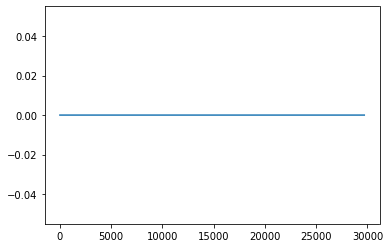

In [10]:
plt.plot(np.sum(y_real - y_pred,axis=1).values)

# save

In [11]:
joblib.dump(tr,'../model/transformer(SP162_to_Y162).pkl')

['../model/transformer(SP162_to_Y162).pkl']